# DEVELOPING A RECURRENT NEURAL NETWORK MODEL FOR STOCK PREDICTION

**Name :** CHANDRAPRIYADHARSHINI C

**Reg.No :** 212223240019

In [21]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [22]:
#Reads the training and testing datasets from CSV files.
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [23]:
#We only use the closing price of the stock.
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [24]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices) #Computes min and max from the training data and scales
scaled_test = scaler.transform(test_prices) #Scales the test data using the same training min and max, so we don't "leak" future information.

In [25]:
#Create sequences for RNN
def create_sequences(data, seq_length):
    x = [] #A sequence of seq_length days of stock prices.
    y = [] #the next days price.
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

#Using the last 60 days prices to predict the next day.
seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)

In [26]:
#Convert to PyTorch tensors
#PyTorch models require tensor inputs, not NumPy arrays.
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [27]:
#Create dataset and DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor) #Combines x trian and y train for easy access.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #Loads data in batches=64

In [28]:
#Define th RNN model(LSTM)
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))

        # Take only the last time step
        out = self.fc(out[:, -1, :])
        return out

In [29]:
#Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Moves model to GPU if available; otherwise CPU
model = RNNModel().to(device)

In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
#Train the model
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

Epoch [10/50], Loss: 0.000809
Epoch [20/50], Loss: 0.000666
Epoch [30/50], Loss: 0.000602
Epoch [40/50], Loss: 0.000552
Epoch [50/50], Loss: 0.000503


Name: CHANDRAPRIYADHARSHINI C

Register Number: 212223240019


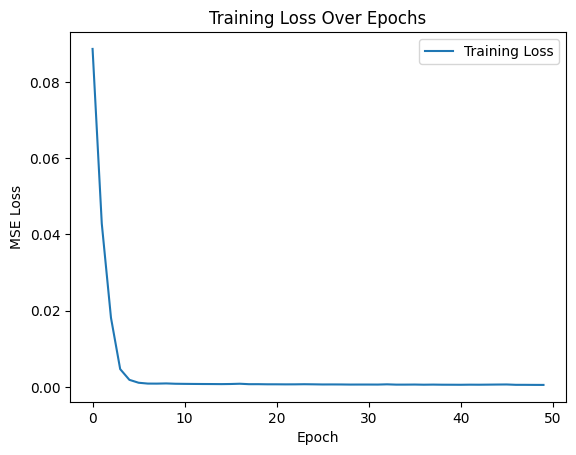

In [33]:
#Plot training loss
print('Name: CHANDRAPRIYADHARSHINI C')
print()
print('Register Number: 212223240019')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [34]:
#Make predictions
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

In [35]:
#Undo normalization to get actual stock prices.
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

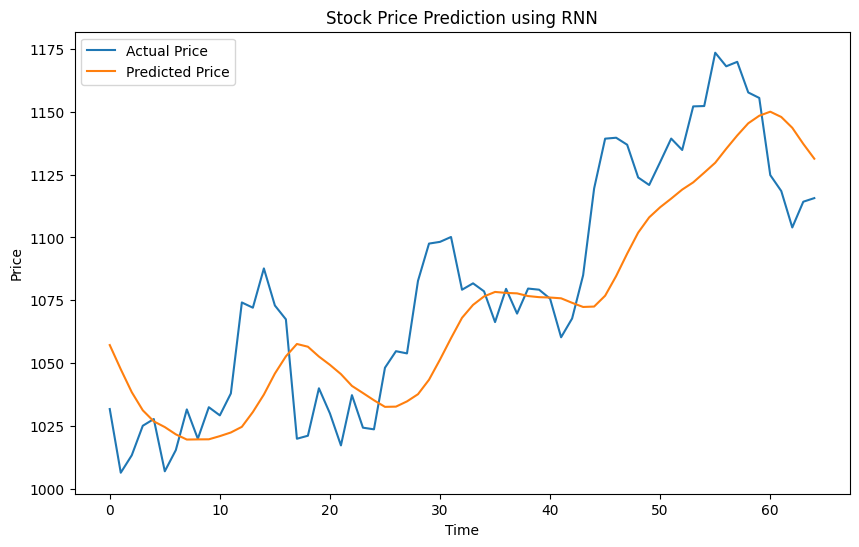

In [36]:
#Plot predicted vs actual prices.
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()

In [37]:
#Print last day's prediction for comparison
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')

Predicted Price: [1131.322]
Actual Price: [1115.65]
